##Make X not baD!

Load X and Y from getting satellite channels 1 and 6 data, see satellite-to-sensor-model.ipynb for more info.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from data_helper_functions import *
from IPython.display import display
pd.options.display.max_columns = 999
%matplotlib inline

In [2]:
with np.load('data/X.npz') as data:
    X = data['X']

with np.load('data/Y.npz') as data:
    Y = data['Y']

In [3]:
print X.shape
print Y.shape

(2544, 2476)
(2544, 14)


Random Forest seems to be giving the best results, so we'll stick with that for now

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
rfr = RandomForestRegressor(oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 14)

In [5]:
rfr.fit(X_train,Y_train)

/home/ubuntu/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:659: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [6]:
rfr.score(X_test,Y_test)

0.030842791854099993

In [7]:
Y_pred = rfr.predict(X_test)
from random import randint
val = randint(0,508)
print Y_pred[val]
print Y_test[val]

[-1898.04073451 -1895.44739133 -1874.99465429 -1862.62083899 -1872.08635517
 -1888.94023789 -1878.36506936 -1899.1076668  -1898.16786753 -1898.20189851
 -1898.21882193 -1898.17638099 -1897.81655789 -1898.10105721]
[-1049.38756217 -1049.66777813 -1049.1949189  -1049.17124527 -1049.44469013
 -1049.60373762 -1049.56861818 -1046.84618117 -1045.290315   -1045.314015
 -1045.0869825  -1044.91115667 -1044.6794105  -1044.81481833]


Maybe I should only use the AOD values since the sensor values are sporadic and don't add as much to the data anyway.  Also, I could remove the rows were the sensor readings are zero.  I could look through the Y rows and make a mask to apply to both X and Y rows.

In [8]:
mask = []
for i,row in enumerate(Y):
    if row[0] == 0:
        mask.append(False)
    else:
        mask.append(True)    

In [9]:
mask = np.array(mask)

In [10]:
X_reduced = X[mask]
Y_reduced = Y[mask][:,-7::]

In [11]:
print X_reduced.shape
print Y_reduced.shape

(2302, 2476)
(2302, 7)


In [12]:
rfr = RandomForestRegressor(oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y_reduced, test_size = 0.3, random_state = 14)

In [13]:
rfr.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [14]:
print rfr.score(X_test,Y_test)
print rfr.oob_score_

0.0953495479344
-0.081979503174


In [15]:
Y_pred = rfr.predict(X_test)

In [30]:
from random import randint
val = randint(0,Y_pred.shape[0])
print Y_pred[val]
print Y_test[val]

[-1935.35396383 -1934.6220952  -1934.62608421 -1934.65860001 -1934.69649184
 -1934.26574289 -1934.69658359]
[-2566.1662685  -2565.99519683 -2566.06676117 -2566.091849   -2566.09353733
 -2565.782831   -2566.08870733]


Let's try Ridge again.

In [17]:
from sklearn.linear_model import Ridge
ridge = Ridge(solver = 'auto')
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y_reduced, test_size = 0.5, random_state = 14)

In [18]:
ridge.fit(X_train,Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [19]:
ridge.score(X_test,Y_test)

-2.0626980586035355

In [20]:
Y_pred = ridge.predict(X_test)

In [21]:
from random import randint
val = randint(0,Y_pred.shape[0]-1)
print Y_pred[val]
print Y_test[val]

[-3656.79602661 -3656.32965664 -3656.54192199 -3656.59705607 -3656.61254918
 -3656.51048482 -3656.63010997]
[-1397.54239183 -1396.65593033 -1396.72254933 -1396.74252183 -1396.76433283
 -1396.5307085  -1396.77221933]


Not too good. Or at least not an improvement over itself even.

I may have to do some feature engineering for the images.  Averaging, filtering or both. I wonder if I do some ratios of channels?  Sort of like the "greenness" parameter that farmers use.  Also, maybe +/- 3 hours is too long for searching for a satellite image. (Reduce to +/- 1 hour?)

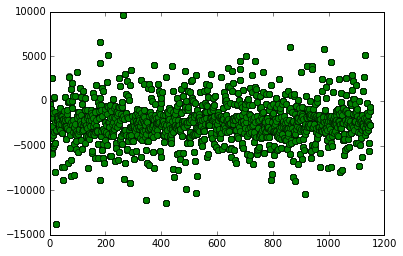

In [91]:
plt.plot(Y_pred,'go');

So, from the plot above, there are values above 0, even though my Y_train and Y_test are all below zero.

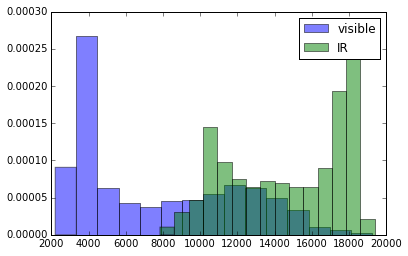

In [186]:
val = randint(0,2301)
_ = plt.hist(X_reduced[:,0:1972][val], alpha = 0.5, normed=True, bins=15, label='visible') #visible light histogram
_ = plt.hist(X_reduced[:,1973:2476][val], alpha = 0.5, normed=True, bins=15, label='IR')
plt.legend(loc='upper right');